In [1]:
# libabries for data exploration.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from helpful_functions import MLFunctions

# time series specific libararies
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.offsetbox import AnchoredText
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [2]:
# load sales data.
sales = pd.read_csv("../../../Data/future_sales/sales_train.csv",
                    usecols=['date', 'shop_id', 'item_id', 'item_price', 'item_cnt_day'])

In [3]:
sales['date'] = pd.to_datetime(sales['date'], format="%d.%m.%Y")
sales = sales.sort_values(by='date')

In [4]:
#helper_function = MLFunctions(sales)
#arr = helper_function.dateNum()
#sales['time'] = arr

In [5]:
items_sold_per_shop = sales.groupby(['date','shop_id']).sum()[['item_cnt_day']]
items_sold_per_shop = items_sold_per_shop.reset_index()

In [6]:
def items_per_shop():
    for i in range(60):
        shop_ = items_sold_per_shop.loc[items_sold_per_shop['shop_id']==i+1, :]
        fig, ax = plt.subplots(figsize=(15,15))
        ax.plot('date', 'item_cnt_day', data=shop_)
        ax.set_title(f'Number of items sold at shop {i+1}')
        plt.show()
#items_per_shop()

In [7]:
sales.head()

,date,shop_id,item_id,item_price,item_cnt_day
49800,2013-01-01,18,5823,2500.0,1.0
29784,2013-01-01,27,5573,849.0,1.0
35476,2013-01-01,7,1006,399.0,1.0
8330,2013-01-01,19,17707,899.0,1.0
57384,2013-01-01,14,19548,149.0,1.0


In [63]:
pd.date_range('2013-2-1', '2013-2-28')

DatetimeIndex(['2013-02-01', '2013-02-02', '2013-02-03', '2013-02-04',
               '2013-02-05', '2013-02-06', '2013-02-07', '2013-02-08',
               '2013-02-09', '2013-02-10', '2013-02-11', '2013-02-12',
               '2013-02-13', '2013-02-14', '2013-02-15', '2013-02-16',
               '2013-02-17', '2013-02-18', '2013-02-19', '2013-02-20',
               '2013-02-21', '2013-02-22', '2013-02-23', '2013-02-24',
               '2013-02-25', '2013-02-26', '2013-02-27', '2013-02-28'],
              dtype='datetime64[ns]', freq='D')

In [67]:
feb_2013 = sales.loc[sales['date'].isin(pd.date_range('2013-2-1', '2013-2-28')),:]

<Axes: xlabel='date'>

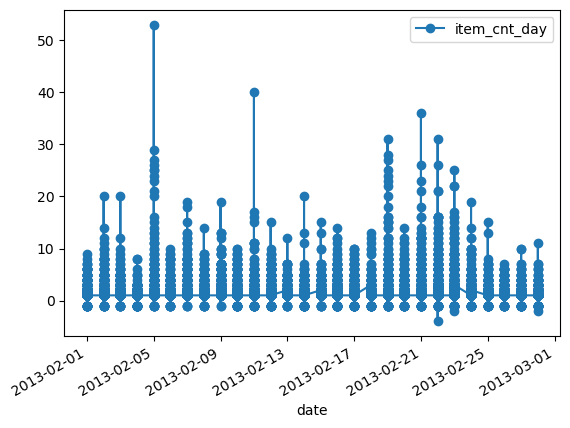

In [69]:
feb_2013.plot('date', 'item_cnt_day', marker='o')

In [9]:
sales.groupby(['time','item_id']).sum()

KeyError: 'time'

In [79]:
test = sales.groupby(['time', 'shop_id']).sum()[['item_price', 'item_cnt_day']]

In [80]:
test

item_price  item_cnt_day
time shop_id                          
0    2           31287.0          24.0
     7           58595.0          89.0
     8           43118.0          50.0
     13           5804.0          31.0
     14          43673.0          66.0
...                  ...           ...
1033 55          38268.0         137.0
     56          48622.0          67.0
     57         105070.0         121.0
     58          85774.0          82.0
     59          43223.0          56.0

[47228 rows x 2 columns]

In [83]:
test2 = sales.groupby(['time', 'shop_id']).count()[['item_id']]
test2

item_id
time shop_id         
0    2             23
     7             87
     8             48
     13            28
     14            60
...               ...
1033 55            49
     56            61
     57           110
     58            71
     59            51

[47228 rows x 1 columns]

In [85]:
test3 = pd.concat([test, test2], axis=1)
test3

item_price  item_cnt_day  item_id
time shop_id                                   
0    2           31287.0          24.0       23
     7           58595.0          89.0       87
     8           43118.0          50.0       48
     13           5804.0          31.0       28
     14          43673.0          66.0       60
...                  ...           ...      ...
1033 55          38268.0         137.0       49
     56          48622.0          67.0       61
     57         105070.0         121.0      110
     58          85774.0          82.0       71
     59          43223.0          56.0       51

[47228 rows x 3 columns]

In [92]:
test3 = test3.reset_index()

In [8]:
sales.head()

,shop_id,item_id,item_price,item_cnt_day,time
date,,,,,
2013-01-01,18,5823,2500.0,1.0,0
2013-01-01,27,5573,849.0,1.0,0
2013-01-01,7,1006,399.0,1.0,0
2013-01-01,19,17707,899.0,1.0,0
2013-01-01,14,19548,149.0,1.0,0


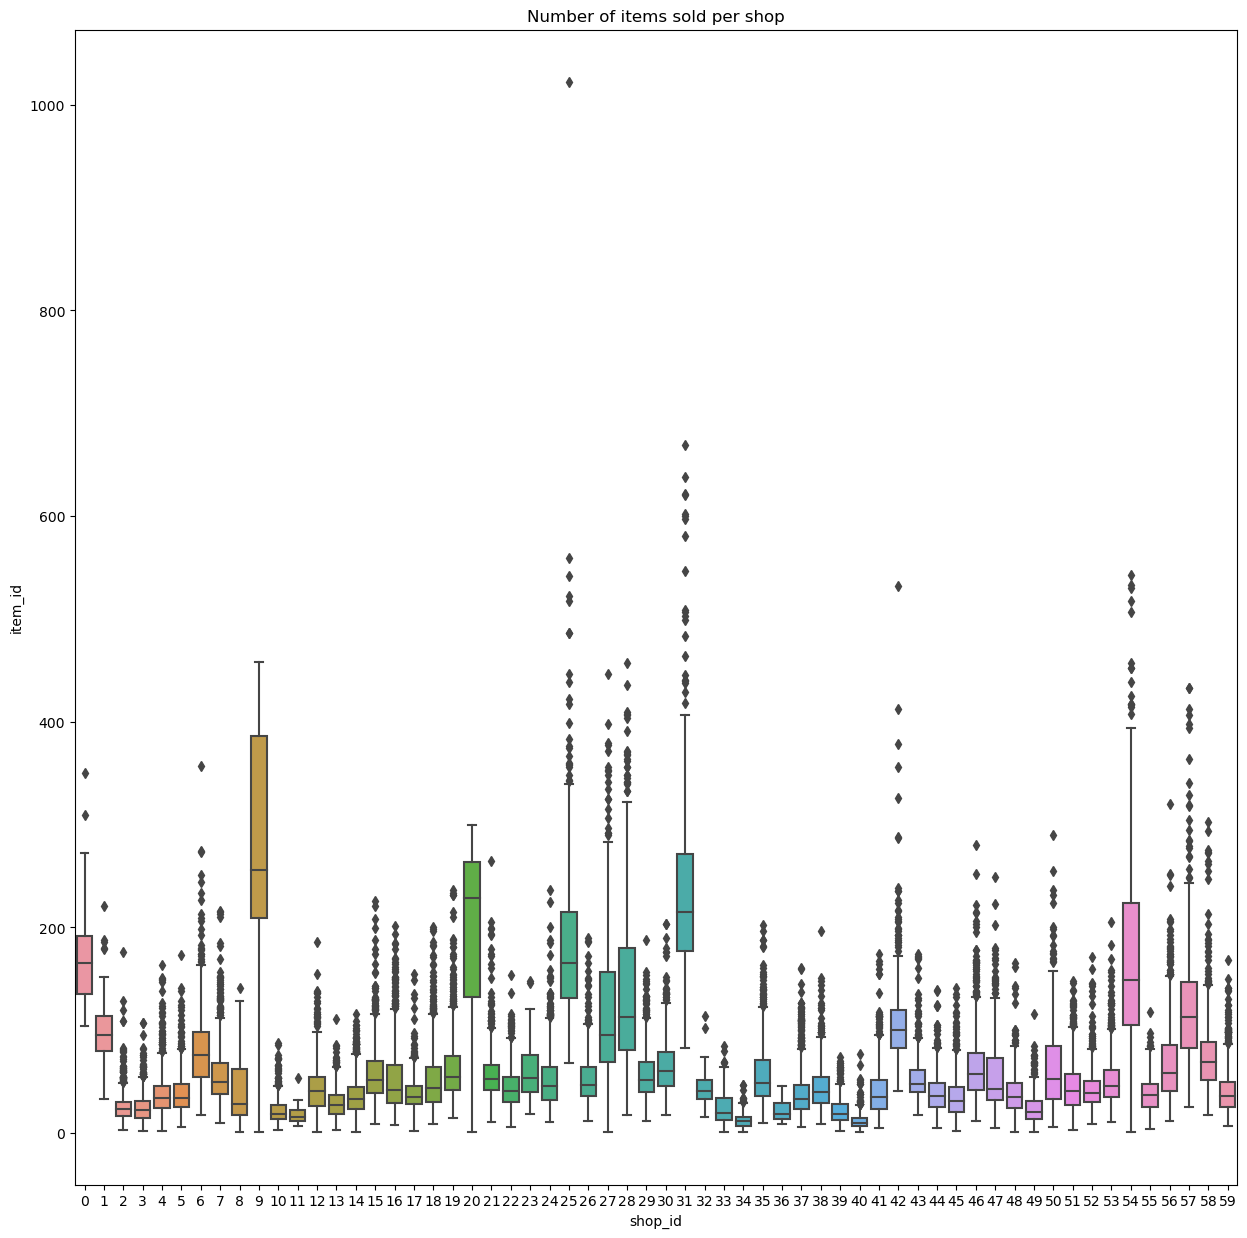

In [98]:
fig, ax = plt.subplots(figsize=(15,15))
sns.boxplot(data=test3, x='shop_id', y='item_id')
ax.set_title('Number of items sold per shop')
plt.show()

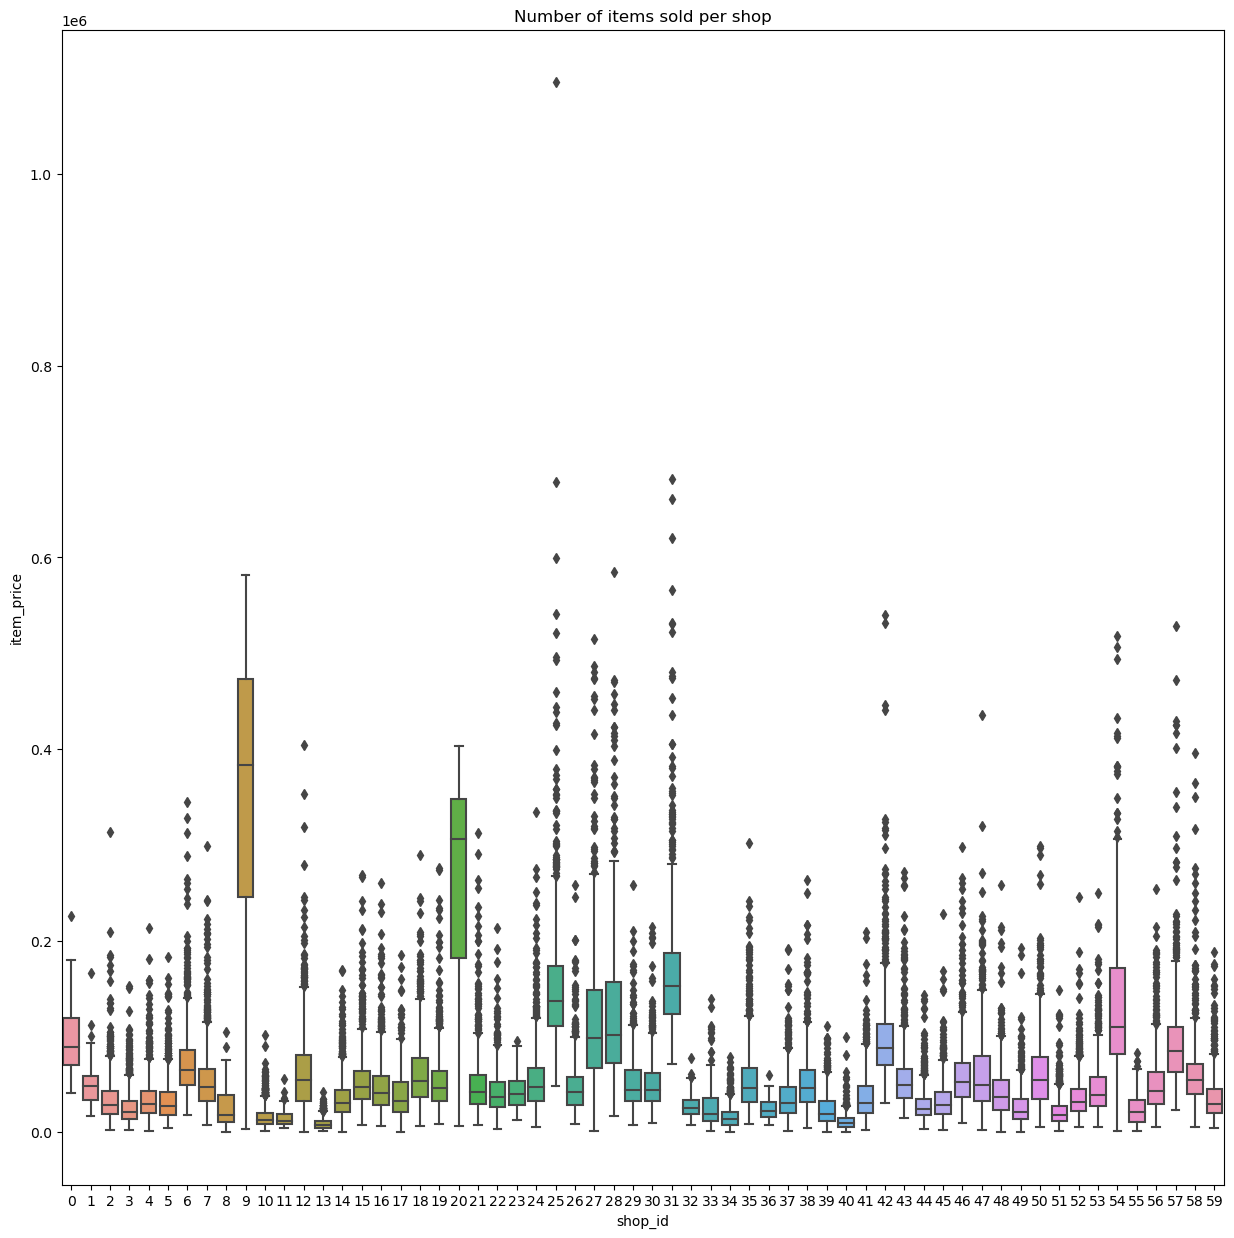

In [100]:
fig, ax = plt.subplots(figsize=(15,15))
sns.boxplot(data=test3, x='shop_id', y='item_price')
ax.set_title('Number of items sold per shop')
plt.show()

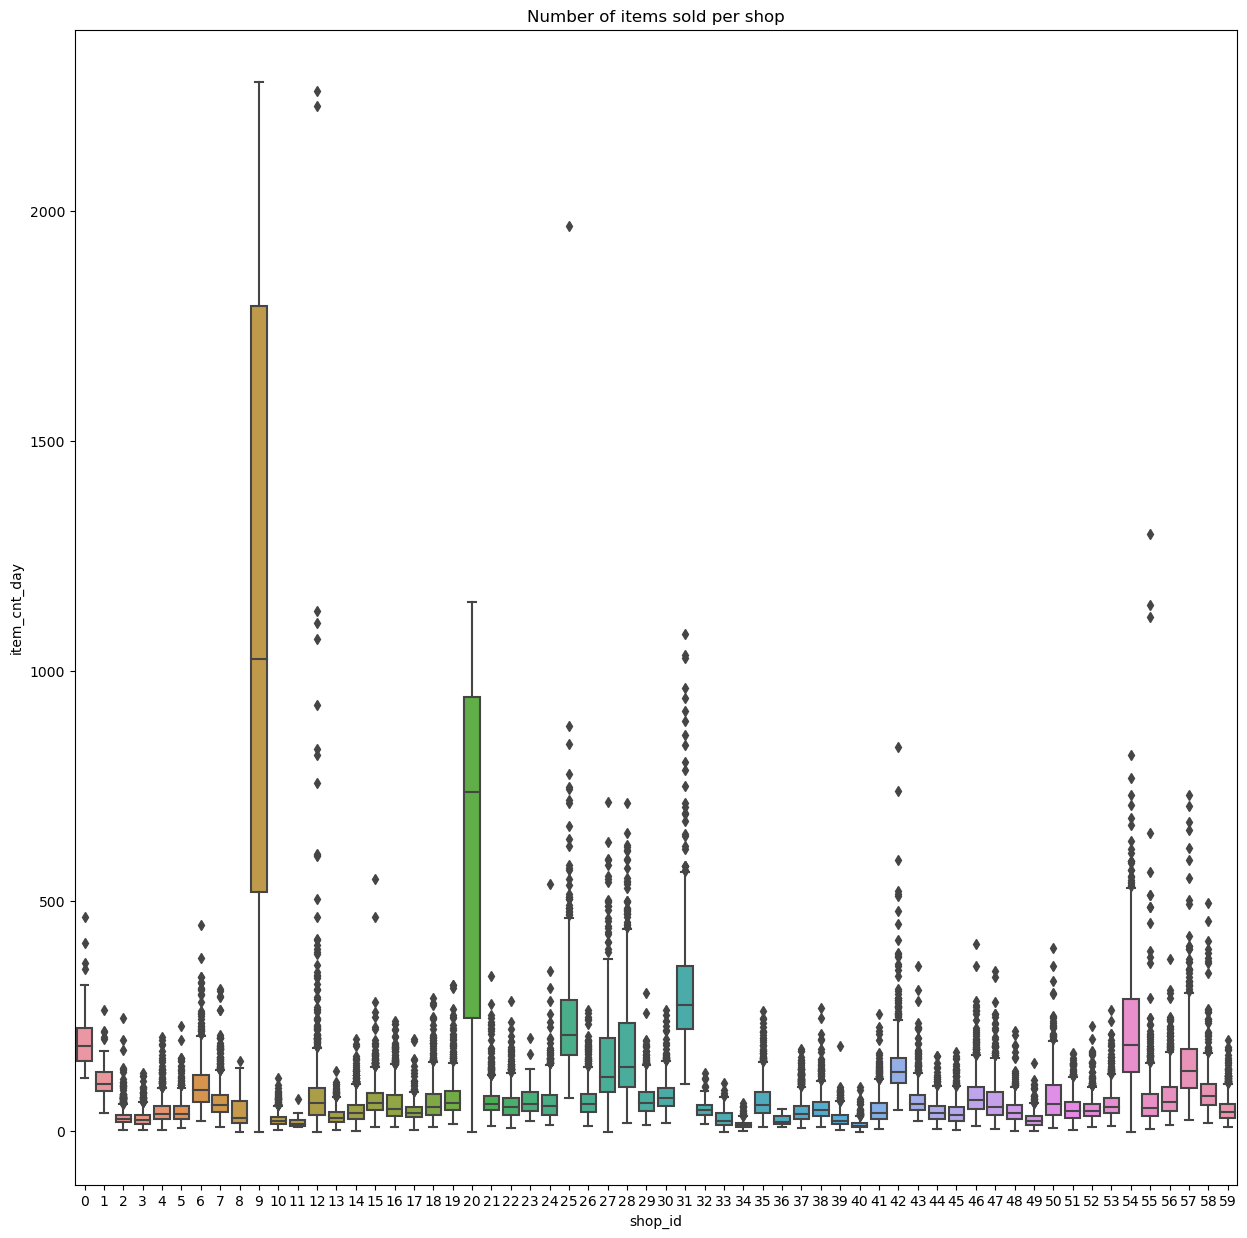

In [102]:
fig, ax = plt.subplots(figsize=(15,15))
sns.boxplot(data=test3, x='shop_id', y='item_cnt_day')
ax.set_title('Number of items sold per shop')
plt.show()

In [75]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ryanholbrook/ts-course-data")

print("Path to dataset files:", path)

100%|██████████| 120k/120k [00:00<00:00, 206kB/s]

Extracting files...
Path to dataset files: C:\Users\Admin\.cache\kagglehub\datasets\ryanholbrook\ts-course-data\versions\14


In [73]:
pip install kagglehub

  Obtaining dependency information for kagglehub from https://files.pythonhosted.org/packages/3c/74/10ea2151b11f8591f82d39c70c1dcc43d0160ba41f8ddb644eb1f5eac348/kagglehub-0.3.4-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/43.0 kB ? eta -:--:--
   --------- ------------------------------ 10.2/43.0 kB ? eta -:--:--
   -------------------------------------- - 41.0/43.0 kB 495.5 kB/s eta 0:00:01
   ---------------------------------------- 43.0/43.0 kB 420.2 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [121]:
from statsmodels.tsa.seasonal import seasonal_decompose
np.random.seed(42)
date_range = pd.date_range(start="2015-01-01", end="2024-12-31", freq="M")
trend = np.linspace(200, 1000, len(date_range))
seasonality = 100 * np.sin(2 * np.pi * (date_range.month / 12))
noise = np.random.normal(0, 50, len(date_range))
sales = trend + seasonality + noise

data = pd.DataFrame({"Date": date_range, "Sales": sales})
data.set_index("Date", inplace=True)

In [123]:
# Perform Decomposition
decomposition = seasonal_decompose(data["Sales"], model="additive", period=12)
trend_component = decomposition.trend
seasonal_component = decomposition.seasonal
residual_component = decomposition.resid

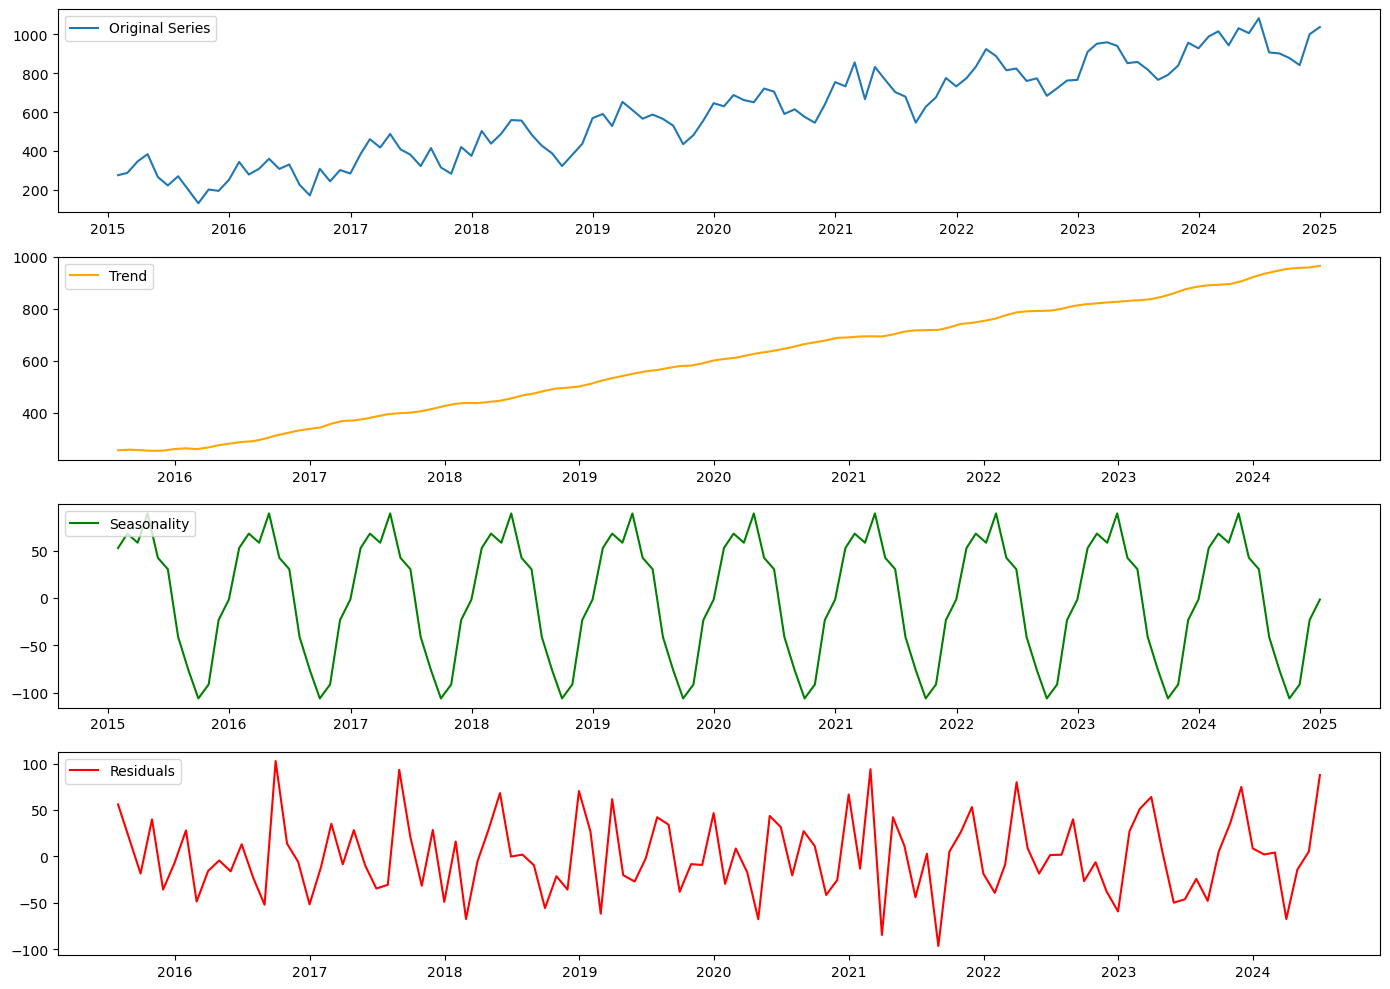

In [129]:
# Plot the decomposition
plt.figure(figsize=(14, 10))

# Original series
plt.subplot(411)
plt.plot(data["Sales"], label="Original Series")
plt.legend(loc="upper left")

# Trend
plt.subplot(412)
plt.plot(trend_component, label="Trend", color="orange")
plt.legend(loc="upper left")

# Seasonality
plt.subplot(413)
plt.plot(seasonal_component, label="Seasonality", color="green")
plt.legend(loc="upper left")

# Residuals
plt.subplot(414)
plt.plot(residual_component, label="Residuals", color="red")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()